In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q xplique
#!cp "/content/drive/MyDrive/Harmonizer zoo/data/cka_imagenet_val.npy" ./
#!cp -r "/content/drive/MyDrive/Saliency Strike Back/data/resnet50_explanations" ./

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.4/191.4 kB 1.7 MB/s eta 0:00:00


In [2]:
import xplique
from xplique.attributions import *
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img, **kwargs):
  img = np.array(img)
  img -= img.min()
  img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')

import seaborn as sns
sns.set(font_scale=2)

<ipython-input-2-ae7f1534161f>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
model = tf.keras.applications.ResNet50V2(classifier_activation=None)

def preprocess(images):
  return tf.keras.applications.resnet_v2.preprocess_input(np.array(images, dtype=np.float32))

102869336/102869336 [==============================] - 0s 0us/step


In [ ]:
import cv2
X = cv2.resize(cv2.imread('tiger.png')[...,::-1], (224, 224))[None, :, :, :]
X = preprocess(X)
Y = tf.one_hot(np.argmax(model.predict(X, 256), -1), 1_000)
X.shape, Y.shape

1/1 [==============================] - 1s 1s/step


((1, 224, 224, 3), TensorShape([1, 1000]))

In [4]:
import cv2
X = cv2.resize(cv2.imread('squirrel.png')[...,::-1], (224, 224))[None, :, :, :]
X = preprocess(X)
Y = tf.one_hot(np.argmax(model.predict(X, 256), -1), 1_000)
X.shape, Y.shape

1/1 [==============================] - 1s 1s/step


((1, 224, 224, 3), TensorShape([1, 1000]))

In [23]:
x0 = cv2.imread('squirrel.png')[...,::-1]

In [5]:
X.shape, Y.shape

((1, 224, 224, 3), TensorShape([1, 1000]))

# Generate and save explanations

In [6]:
model = tf.keras.applications.ResNet50V2(classifier_activation=None)
feature_model = tf.keras.Model(model.input, model.layers[-2].output)

In [ ]:
Bank = feature_model.predict(X, batch_size=128)
Bank.shape

40/40 [==============================] - 4s 53ms/step


(5000, 2048)

In [7]:
from xplique.attributions import *
from xplique.metrics import *

In [8]:
def permute_ax1(x):
  x = x.copy()
  x = np.moveaxis(x, 1, 0)
  np.random.shuffle(x)
  x = np.moveaxis(x, 1, 0)
  return x

def random_permute(x):
  x = np.array(x).copy()
  s = x.shape
  x = x.reshape((len(x), -1, 3))
  x = permute_ax1(x)
  return x.reshape(s)

def downsample_upsample(x):
  s = (x.shape[-3], x.shape[-2])
  x = tf.image.resize(x, (8, 8), method="bilinear")
  x = tf.image.resize(x, s, method="nearest")
  return x

def local_permute(x):
  s = (x.shape[-3], x.shape[-2])
  x = tf.image.resize(x, (8, 8), method="bilinear")
  x = random_permute(x)
  x = tf.image.resize(x, s, method="nearest")
  return x

def scramble_phase(x):
  spectrum = np.fft.fft2(x)
  amplitude = np.abs(spectrum)

  phase = np.angle(spectrum)
  phase = random_permute(phase)
  #phase = np.random.normal(phase.mean(), phase.std(), phase.shape)

  x = np.abs(np.fft.ifft2(amplitude * np.exp(1j * phase)))

  return x

def scramble_amplitude(x):
  spectrum = np.fft.fft2(x)

  amplitude = np.abs(spectrum)
  amplitude = random_permute(amplitude)

  phase = np.angle(spectrum)

  x = np.abs(np.fft.ifft2(amplitude * np.exp(1j * phase)))

  return x


baselines = {
    'zero': lambda x : tf.zeros(x.shape),
    'uniform': lambda x : tf.random.uniform(x.shape, -1, 1),
    'normal': lambda x : tf.clip_by_value(tf.random.normal(x.shape), -1, 1),
    'permutation': lambda x : random_permute(x),
    'local_mean': lambda x : downsample_upsample(x),
    'local_permutation': lambda x : local_permute(x),
    'mean': lambda x : np.ones(x.shape) * np.mean(x, (1, 2))[:, None, None, :],
    'median': lambda x : np.ones(x.shape) * np.median(x, (1, 2))[:, None, None, :],
    'random_color': lambda x : np.ones(x.shape) * (np.random.rand(3) * 2 - 1.),
    'scramble_phase': lambda x : scramble_phase(x),
    'scramble_amplitude': lambda x : scramble_amplitude(x)
}

In [9]:
def generate_path(images, explanations, baseline_func, steps=10):
  images_flatten = np.array(images).reshape((len(images), -1, images.shape[-1]))

  min_img = np.min(images, (1,2,3))
  max_img = np.max(images, (1,2,3))

  if len(explanations.shape) == 4:
    explanations = np.mean(explanations, -1)

  explanations_flatten = explanations.reshape((len(explanations), -1))
  most_important_features = np.argsort(explanations_flatten, axis=-1)[:, ::-1]

  baselines = np.array(baseline_func(images))
  baselines_flatten = baselines.reshape((len(images), -1, images.shape[-1]))

  steps = np.linspace(0, baselines_flatten.shape[1], steps + 1, dtype=np.int32)

  start = images_flatten
  end = baselines_flatten

  ret = []

  for step in steps:
    ids_to_flip = most_important_features[:, :step]
    batch_inputs = start.copy()

    for i, ids in enumerate(ids_to_flip):
      batch_inputs[i, ids] = end[i, ids]

    batch_inputs = batch_inputs.reshape(images.shape)
    batch_inputs = np.clip(batch_inputs, min_img[:, None, None, None], max_img[:, None, None, None])
    ret.append(batch_inputs)

  return ret

In [10]:
from xplique.attributions import *
H = Saliency(model)(X, Y)
H.shape

TensorShape([1, 224, 224, 1])

mkdir: cannot create directory ‘baseline’: File exists


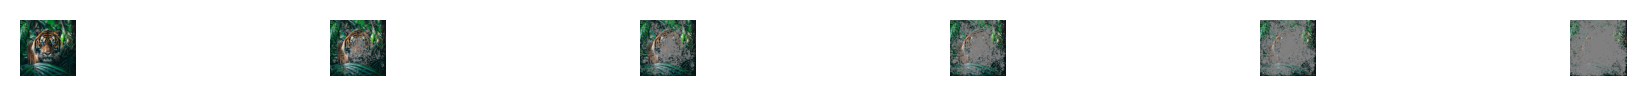

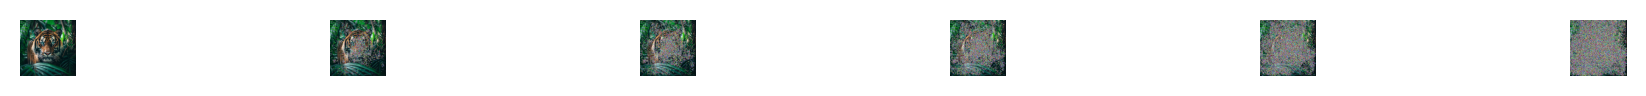

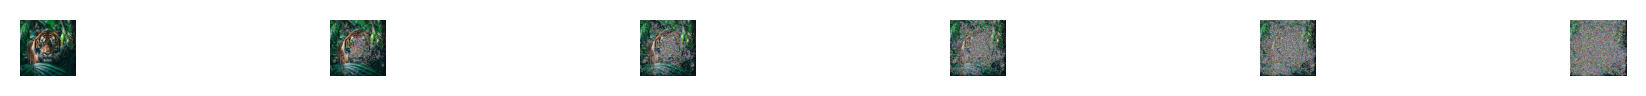

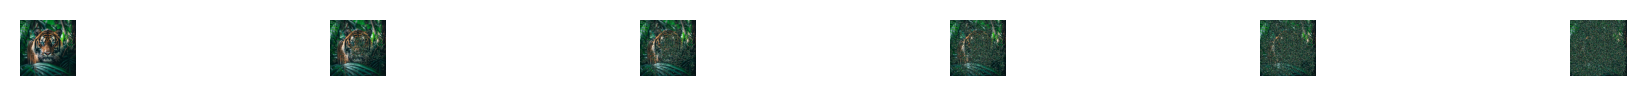

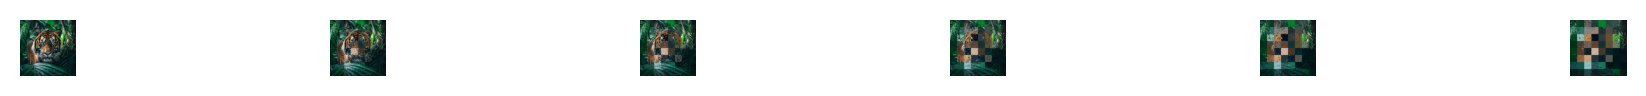

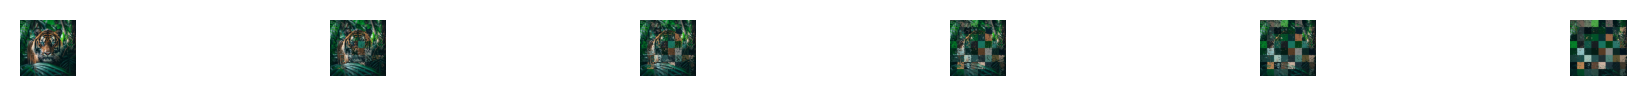

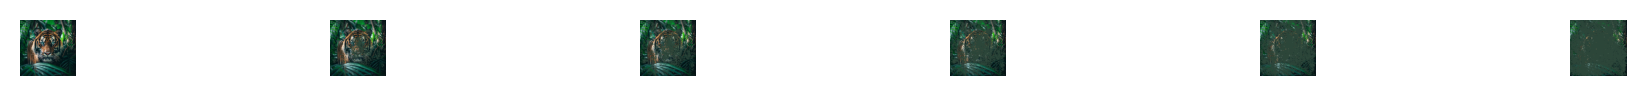

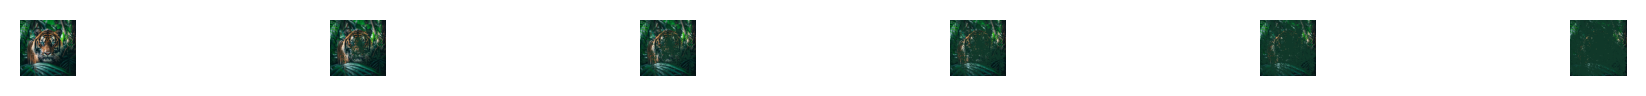

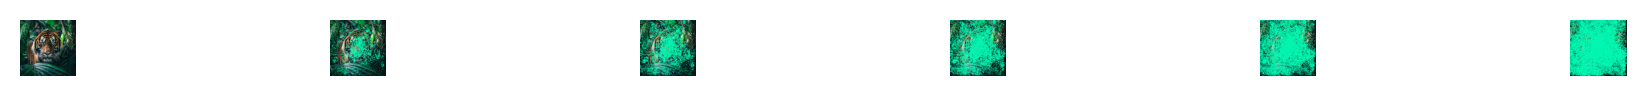

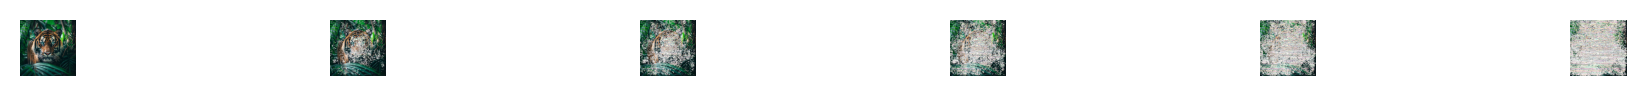

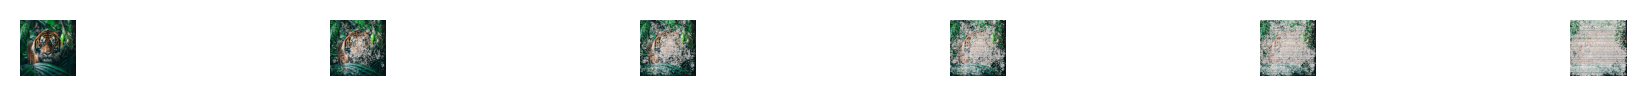

In [ ]:
steps = 6
set_size(10, 1)
!mkdir baseline

for baseline_name, baseline_func in baselines.items():
  chunks = generate_path(np.array(X), np.array(H), baseline_func, steps=steps)

  for i in range(steps):
    plt.subplot(1, steps, i+1)
    show(chunks[i][0])
  #plt.title(baseline_name)
  plt.tight_layout()
  plt.savefig('baseline/'+baseline_name+'.png', dpi=300, transparent=True)
  plt.show()

In [27]:
set_size(9, 9)
show(x0.astype(np.float32))
show(cv2.resize(np.clip(H[0], 0, np.percentile(H, 99)), (1024, 1024)), cmap="viridis", alpha=0.35)
plt.tight_layout()
plt.savefig('explanation_squi.png', dpi=300, transparent=True)

Output hidden; open in https://colab.research.google.com to view.

In [28]:
steps = 6
set_size(9, 9)
!rm -rf baseline_pic
!mkdir baseline_pic

for baseline_name, baseline_func in baselines.items():
  chunks = generate_path(np.array(X), np.array(H), baseline_func, steps=steps)
  show(chunks[1][0])
  #plt.title(baseline_name)
  plt.tight_layout()
  plt.savefig('baseline_pic/'+baseline_name+'.png', dpi=300, transparent=True)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [29]:
!zip -r baselines.zip baseline_pic/

updating: baseline_pic/ (stored 0%)
updating: baseline_pic/local_mean.png (deflated 18%)
updating: baseline_pic/normal.png (deflated 19%)
updating: baseline_pic/mean.png (deflated 18%)
updating: baseline_pic/local_permutation.png (deflated 18%)
updating: baseline_pic/median.png (deflated 18%)
updating: baseline_pic/permutation.png (deflated 19%)
updating: baseline_pic/uniform.png (deflated 19%)
updating: baseline_pic/scramble_phase.png (deflated 19%)
updating: baseline_pic/scramble_amplitude.png (deflated 19%)
updating: baseline_pic/random_color.png (deflated 18%)
updating: baseline_pic/zero.png (deflated 18%)


In [ ]:
!zip -r baseline_path.zip baseline/

  adding: baseline/ (stored 0%)
  adding: baseline/local_mean.png (deflated 1%)
  adding: baseline/normal.png (deflated 1%)
  adding: baseline/mean.png (deflated 1%)
  adding: baseline/local_permutation.png (deflated 1%)
  adding: baseline/median.png (deflated 1%)
  adding: baseline/permutation.png (deflated 1%)
  adding: baseline/uniform.png (deflated 1%)
  adding: baseline/scramble_phase.png (deflated 1%)
  adding: baseline/scramble_amplitude.png (deflated 1%)
  adding: baseline/random_color.png (deflated 1%)
  adding: baseline/zero.png (deflated 1%)


In [30]:
!cp base*.zip "/content/drive/MyDrive"

In [ ]:
steps = 6
set_size(10, 4)

for baseline_name, baseline_func in baselines.items():
  chunks = generate_path(np.array(X), np.array(H), baseline_func, steps=steps)

  for i in range(steps):
    plt.subplot(1, steps, i+1)
    show(chunks[i][0])
  plt.title(baseline_name)
  plt.tight_layout()
  #plt.savefig('baseline/'+baseline_name+'.png', dpi=300, transparent=True)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def l2_pairwise(a, b):
  na = tf.reduce_sum(tf.square(a), 1)
  nb = tf.reduce_sum(tf.square(b), 1)

  na = tf.reshape(na, [-1, 1])
  nb = tf.reshape(nb, [1, -1])

  # return pairwise euclidead difference matrix
  d = tf.sqrt(tf.maximum(na - 2*tf.linalg.matmul(a, b, False, True) + nb, 0.0))
  return d

def compute_ood_score(images):
  activations = feature_model.predict(images, batch_size=128)
  distances = l2_pairwise(activations, Bank)
  scores = np.min(distances, -1)

  return scores

In [ ]:
steps = 20

RESULTS = {}

for baseline_name, baseline_func in baselines.items():
  RESULTS[baseline_name] = []

  chunks = generate_path(np.array(X[:len(H)]), np.array(H), baseline_func, steps=steps)

  for step_id in range(steps):
    ood_scores = compute_ood_score(chunks[step_id])
    RESULTS[baseline_name].append((step_id, ood_scores))

  print("done for", baseline_name)

  fn = "ood_scores_resnet.npy"
  np.save(fn, RESULTS)

!cp {fn} "/content/drive/MyDrive/Metrics Baseline/Data/results_resnet"


4/4 [==============================] - 0s 48ms/step
done for zero
4/4 [==============================] - 0s 49ms/step
done for uniform
4/4 [==============================] - 0s 48ms/step
done for normal
4/4 [==============================] - 0s 49ms/step
done for permutation
4/4 [==============================] - 0s 49ms/step
done for local_mean
4/4 [==============================] - 0s 49ms/step
done for local_permutation
4/4 [==============================] - 0s 49ms/step
done for mean
4/4 [==============================] - 0s 49ms/step
done for median
4/4 [==============================] - 0s 49ms/step
done for random_color
4/4 [==============================] - 0s 49ms/step
done for scramble_phase
4/4 [==============================] - 0s 49ms/step
done for scramble_amplitude


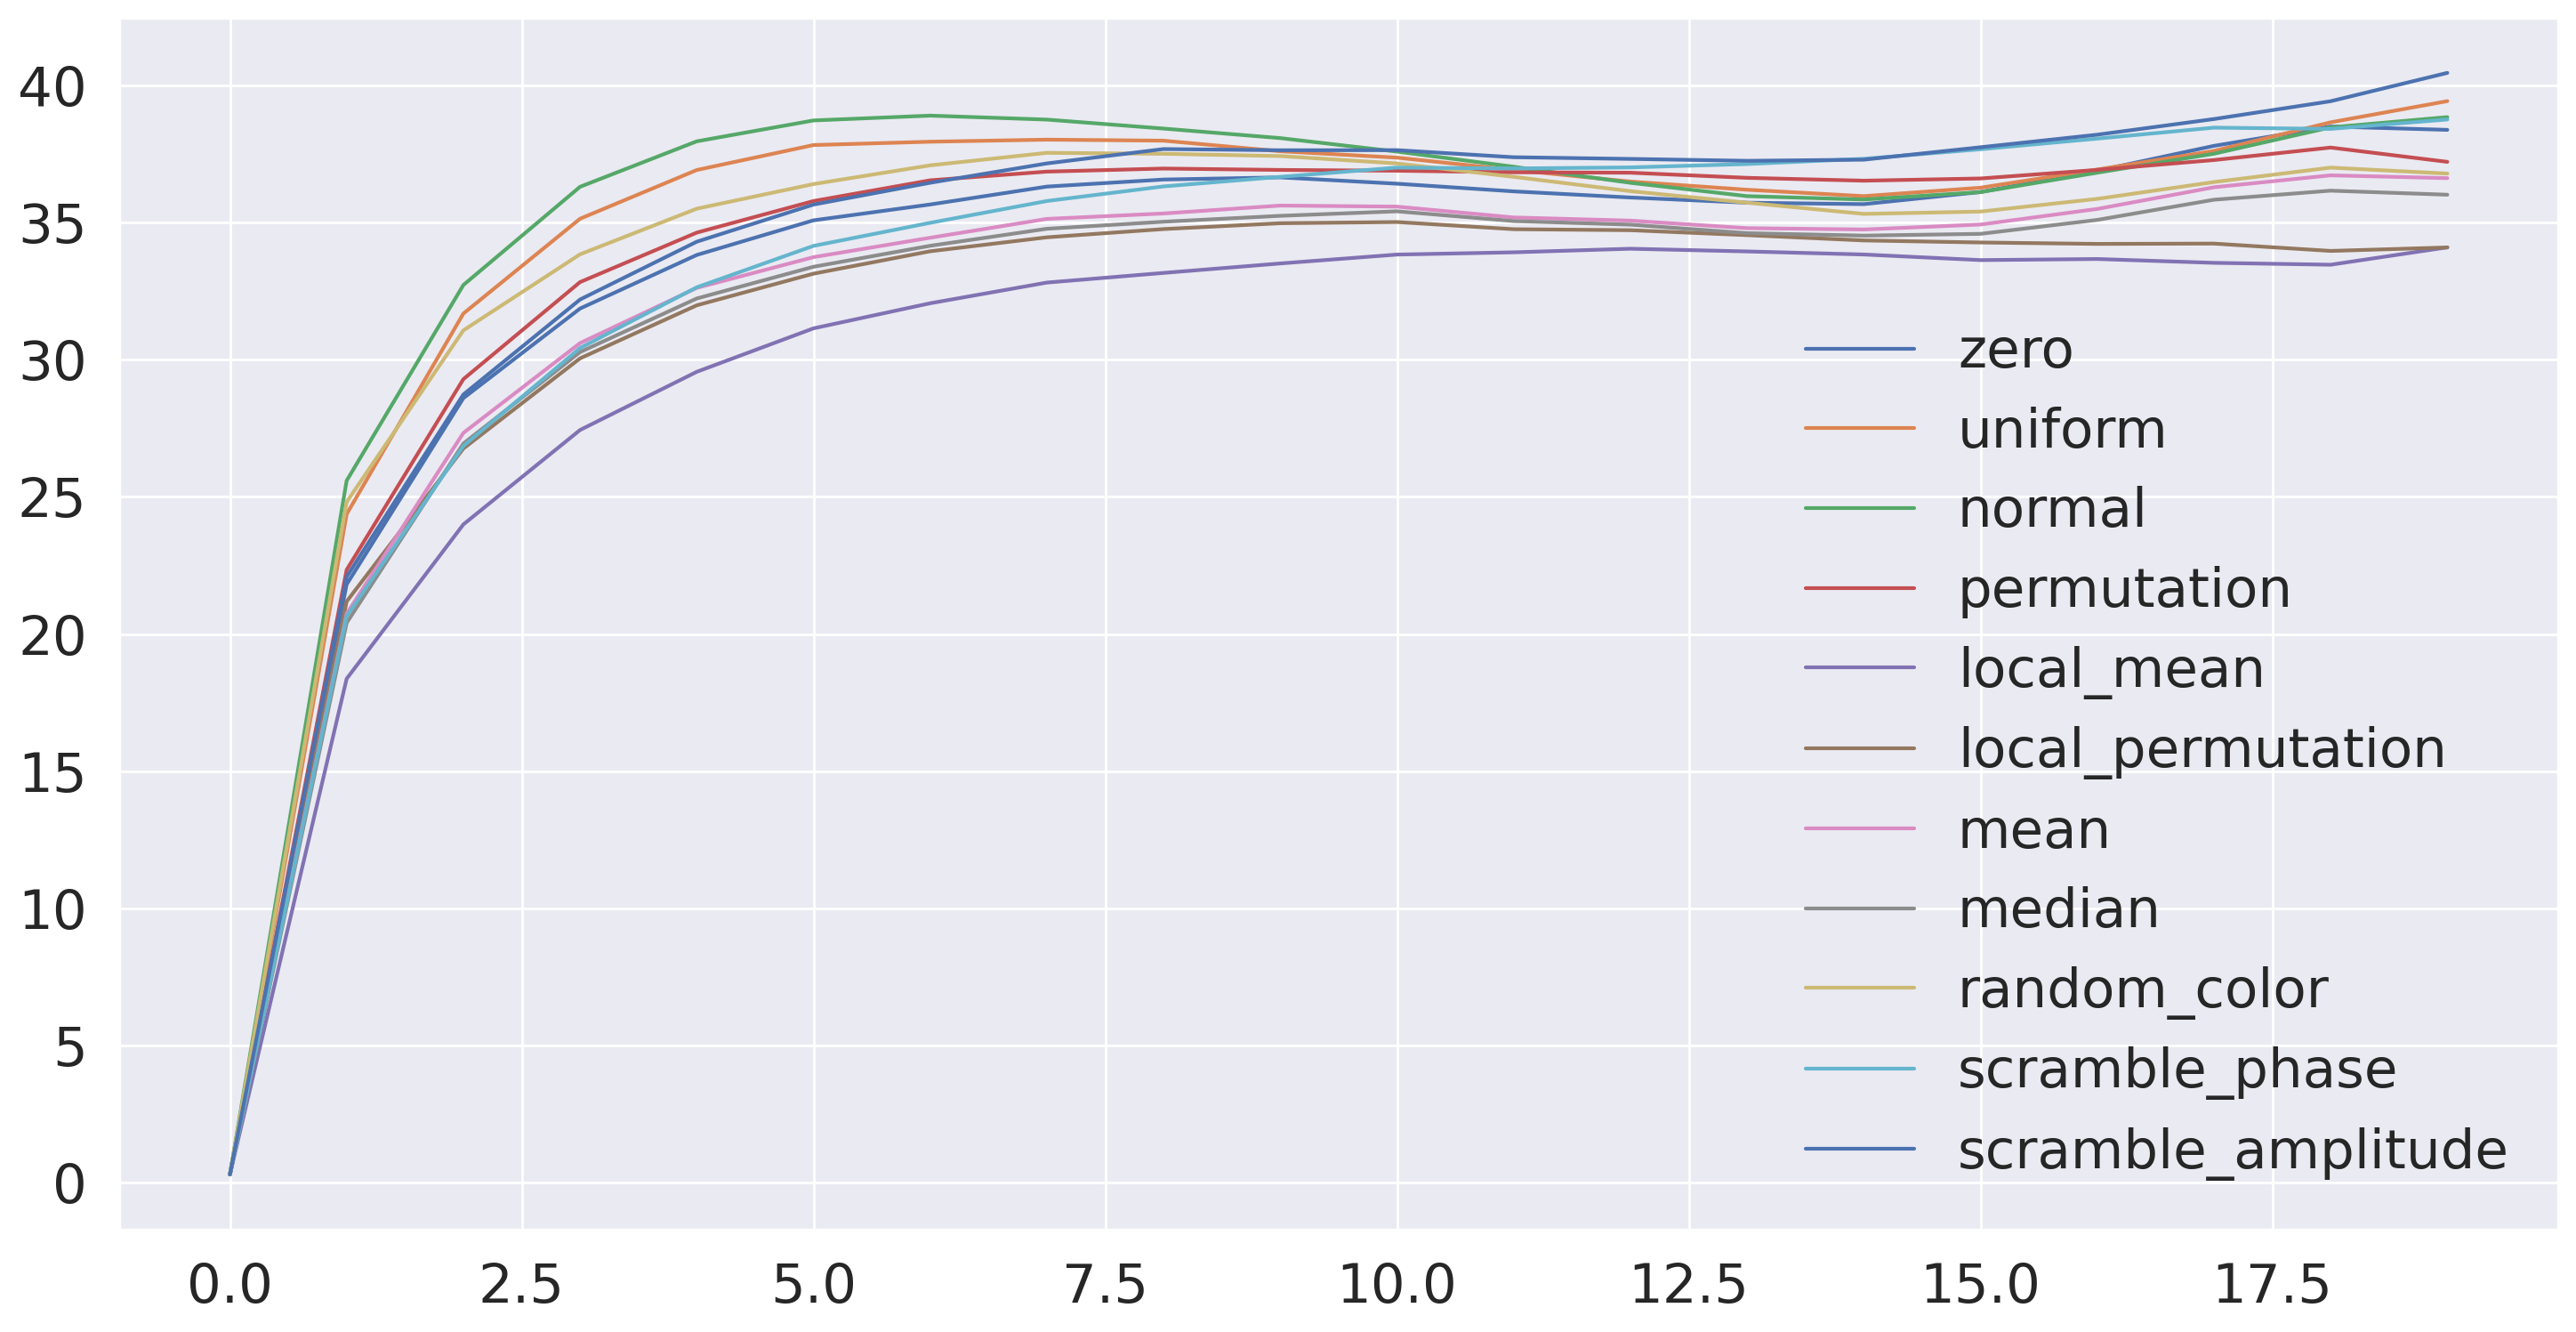

In [ ]:
set_size(15, 8)

for baseline_name, baseline_func in baselines.items():
  scores = [np.mean(d) for _, d in RESULTS[baseline_name]]
  plt.plot(scores, label=baseline_name)

plt.tight_layout()
plt.legend()

(1024, 1024, 1) (1024, 1024, 3)


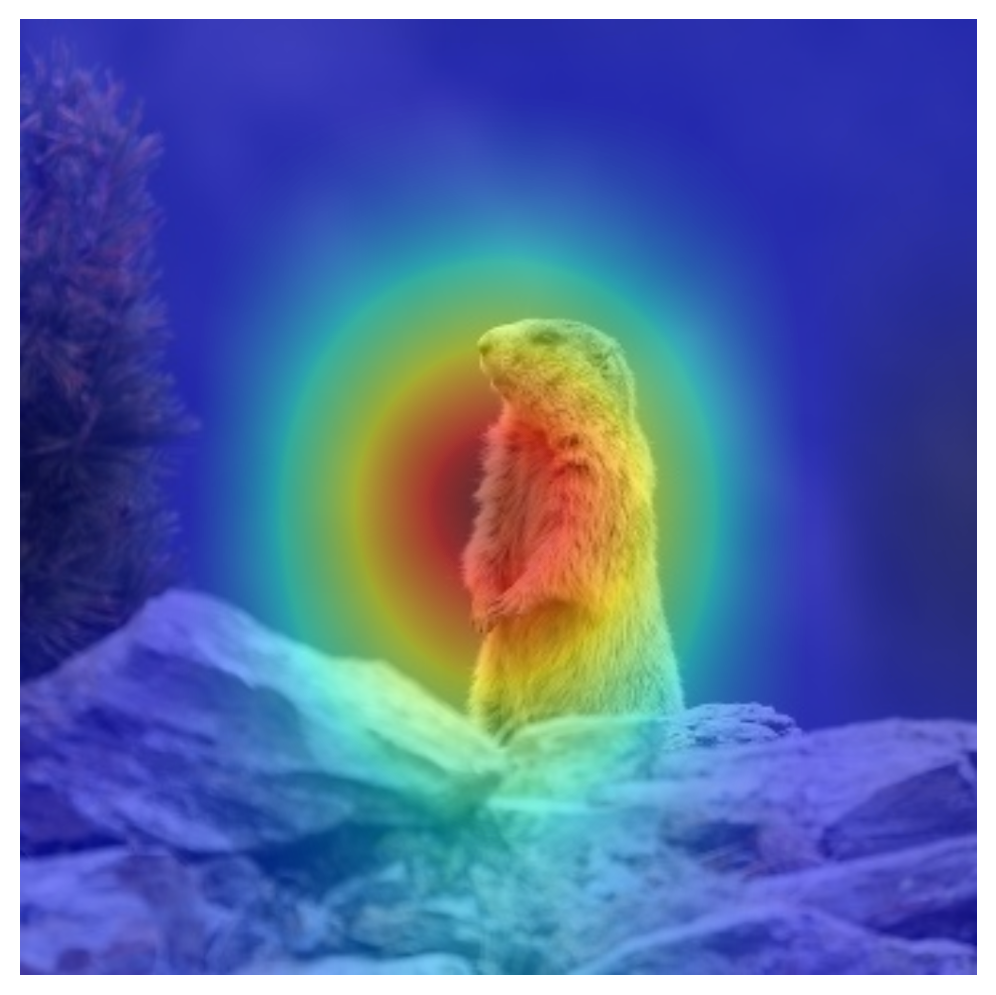

In [ ]:
import cv2

h = np.array([
    [0.0, 0.1, 0.0],
    [0.0, 1.0, 0.0],
    [0.05, 0.3, 0.01],
])
h = tf.image.resize(h[:, :, None], (1024, 1024), method="bicubic")

img = cv2.imread('marmotte.jpg').astype(np.float32)[...,::-1] / 127.0 - 1.0
img = tf.image.resize(img, (1024, 1024))
show(img)
show(h, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.savefig('h.png', dpi=300, transparent=True)
print(h.shape, img.shape)

In [ ]:
for b_text, b_function in baselines.items():
  b0 = np.array(b_function(img))

  switch = np.array(h > 0.5).astype(np.float32)
  p = img * switch + b0 * (1.0 - switch)

  show(p)
  plt.tight_layout()
  plt.savefig(f'{b_text}.png', dpi=300, transparent=True)
  plt.show()

In [ ]:
l = 300
bs = 128

deletion = Deletion(model, X[:l], Y[:l], batch_size=bs, steps=5, baseline_mode = 0.0)
insertion = Insertion(model, X[:l], Y[:l], batch_size=bs, steps=5)
muf = MuFidelity(model, X[:l], Y[:l], batch_size=bs, nb_samples=128, grid_size=12)

In [ ]:
import os

l = 300
bs = 128

for baseline_text, baseline_func in baselines.items():
  RESULTS = []

  deletion = Deletion(model, X[:l], Y[:l], batch_size=bs, steps=5, baseline_mode = baseline_func)
  insertion = Insertion(model, X[:l], Y[:l], batch_size=bs, steps=5, baseline_mode = baseline_func)
  muf = MuFidelity(model, X[:l], Y[:l], batch_size=bs, nb_samples=128, grid_size=12, baseline_mode = baseline_func)

  for p in os.listdir('resnet50_explanations'):
    h = np.load('resnet50_explanations/'+p)[:l]

    if len(h.shape) == 4:
      h = np.mean(h, -1)

    h = np.abs(h)

    s_del = deletion(h)
    s_ins = insertion(h)
    s_muf = muf(h)

    print(p, s_del, s_ins, s_muf)
    RESULTS.append((p, s_del, s_ins, s_muf))

  fn = baseline_text + ".npy"
  np.save(fn, RESULTS)
  !cp {fn} "/content/drive/MyDrive/Metrics Baseline/Data/results_resnet"



/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


resnet50_GuidedBackprop.npy 0.6811357736587524 0.8954004049301147 0.08076419444059273
resnet50_Occlusion.npy 0.667534589767456 0.8157618641853333 0.08499472063482938
resnet50_SobolAttributionMethod.npy 0.734421968460083 0.9182529449462891 0.07314966805950993
resnet50_Saliency.npy 0.7187615036964417 0.8301159143447876 0.08900482235893073
resnet50_IntegratedGradients.npy 0.7095991969108582 0.841249942779541 0.08649759957555977
resnet50_VarGrad.npy 0.7190834879875183 0.9057377576828003 0.09527287917405133
resnet50_SmoothGrad.npy 0.6913260817527771 0.8525203466415405 0.09477009992815615
resnet50_SquareGrad.npy 0.7290462255477905 0.9075807332992554 0.0910479856678823
resnet50_GradCAMPP.npy 0.7449851632118225 0.9352491497993469 0.11406026270734493
resnet50_DeconvNet.npy 0.6876569986343384 0.8195103406906128 0.12757672234296624
resnet50_GradCAM.npy 0.7758234143257141 0.9301424026489258 0.0853205781514808


In [ ]:
import os

for p in os.listdir('resnet50_explanations'):
  h = np.load('resnet50_explanations/'+p)[:l]

  if len(h.shape) == 4:
    h = np.mean(h, -1)

  h = np.abs(h)

  s_del = deletion(h)
  s_ins = insertion(h)
  s_muf = muf(h)

  print(p, s_del, s_ins, s_muf)

resnet50_GradCAM.npy 0.7874435186386108 0.9272844195365906 0.06702462222518364
resnet50_GuidedBackprop.npy 0.7104595303535461 0.9181774258613586 0.06269835176444336
resnet50_HsicAttributionMethod.npy 0.7270568013191223 0.9253481030464172 0.057911880747071987
resnet50_GradientInput.npy 0.7567116022109985 0.8750414848327637 0.05083232033901102


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


resnet50_Occlusion.npy 0.7078730463981628 0.8360959887504578 0.06555307200310324
resnet50_SquareGrad.npy 0.7466303110122681 0.9175025820732117 0.07152428994165462
resnet50_VarGrad.npy 0.7455980181694031 0.919355571269989 0.07226865606645876
resnet50_SobolAttributionMethod.npy 0.7437445521354675 0.9232309460639954 0.05772241505792069
resnet50_SmoothGrad.npy 0.7382704615592957 0.898871123790741 0.07799797402674685
resnet50_DeconvNet.npy 0.768138587474823 0.8438582420349121 0.1385666403192454
resnet50_Saliency.npy 0.7676782608032227 0.8525184392929077 0.0723284043984989
resnet50_Rise.npy 0.7644363045692444 0.9367285966873169 0.06618524118298776
resnet50_GradCAMPP.npy 0.7541747689247131 0.931303858757019 0.09297190683362602
resnet50_IntegratedGradients.npy 0.7526863813400269 0.8893162608146667 0.06854749778070868


In [ ]:
to_improve = [
 'resnet50_GuidedBackprop.npy',
 'resnet50_GradientInput.npy',
 'resnet50_SquareGrad.npy',
 'resnet50_VarGrad.npy',
 'resnet50_SmoothGrad.npy',
 'resnet50_DeconvNet.npy',
 'resnet50_Saliency.npy',
 'resnet50_IntegratedGradients.npy']

In [ ]:
def low_pass_mask(size, bandwith):
    center = (int(size/2), int(size/2))
    Y, X = np.ogrid[:size, :size]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= bandwith
    mask = mask.astype(np.float32)

    return mask

def cut_freq(phis, bandwith):
  if len(phis.shape) == 4:
    phis = np.mean(phis, -1)
  phis = np.abs(phis)

  specs = np.fft.fft2(phis)
  mask = np.fft.fftshift(low_pass_mask(224, bandwith))
  specs *= mask

  phis_cutted = np.fft.ifft2(specs).astype(np.float32)
  return phis_cutted

In [ ]:
for p in to_improve:
  h = np.load('resnet50_explanations/'+p)[:l]

  if len(h.shape) == 4:
    h = np.mean(h, -1)

  h = np.abs(h)

  for sigma in [100, 50, 20, 15, 10, 8, 5, 3]:

    h_sigma = cut_freq(h, sigma)

    s_del = deletion(h_sigma)
    s_ins = insertion(h_sigma)
    #s_muf = muf(h)

    print(p, sigma, s_del, s_ins, s_ins - s_del)

  print('\n\n\n')


In [ ]:
for p in to_improve:
  h = np.load('resnet50_explanations/'+p)[:l]

  if len(h.shape) == 4:
    h = np.mean(h, -1)

  h = np.abs(h)

  for sigma in [8, 5]:

    h_sigma = cut_freq(h, sigma)

    s_del = deletion(h_sigma)
    s_ins = insertion(h_sigma)
    s_muf = muf(h_sigma)

    print(p, sigma, s_del, s_ins, s_ins - s_del, s_muf)

  print('\n\n\n')


<ipython-input-20-e985ffe7b816>:19: ComplexWarning: Casting complex values to real discards the imaginary part
  phis_cutted = np.fft.ifft2(specs).astype(np.float32)


resnet50_GuidedBackprop.npy 8 0.6913203001022339 0.9108409881591797 0.2195206880569458 0.06090380947505527
resnet50_GuidedBackprop.npy 5 0.7178225517272949 0.9180701971054077 0.2002476453781128 0.058193463520230096




resnet50_GradientInput.npy 8 0.7478708624839783 0.8778724670410156 0.13000160455703735 0.05014007755957404
resnet50_GradientInput.npy 5 0.765465259552002 0.8876684904098511 0.12220323085784912 0.049988370977192664




resnet50_SquareGrad.npy 8 0.7384991645812988 0.9213959574699402 0.18289679288864136 0.06953857843177876
resnet50_SquareGrad.npy 5 0.7556474804878235 0.9322643280029297 0.1766168475151062 0.06959643186330292




resnet50_VarGrad.npy 8 0.7430763840675354 0.9228439331054688 0.17976754903793335 0.06962328480168234
resnet50_VarGrad.npy 5 0.7531355619430542 0.9259392023086548 0.17280364036560059 0.0697130876958039




resnet50_SmoothGrad.npy 8 0.729398787021637 0.9193663597106934 0.1899675726890564 0.07743030742016327
resnet50_SmoothGrad.npy 5 0.7427111268043518 